# Gold Prices Safe Haven Asset Analysis

In this project, I analyzed the behavior of gold prices during major financial crises to assess its role as a safe-haven asset. Using historical data from 1993 to 2022, I examined gold's performance across different timeframes (daily, monthly, and quarterly) and evaluated key financial metrics, including returns, volatility, and drawdowns.

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
from matplotlib import dates as mdates

## Loading and Cleaning the Data

Reads three datasets: Daily, Monthly, and Quarterly gold price data.

In [16]:
def load_and_clean_data():
    """Load and clean all gold price datasets"""
    # Load raw data
    daily_df = pd.read_csv('gold_data/Daily_Gold_Price_on_World.csv')
    monthly_df = pd.read_csv('gold_data/Monthly_Gold_Price_on_World.csv')
    quarterly_df = pd.read_csv('gold_data/Quarterly_Gold_Price_on_World.csv')
    
    def clean_dataset(df, freq):
        """Clean individual dataset"""
        # Create copy and standardize column names
        df = df.copy()
        df.columns = [str(col).strip().replace(' ', '_').replace('(', '').replace(')', '').lower() 
                     for col in df.columns]
        
        # Fix specific column names
        rename_map = {
            'thai_baht_thb': 'thai_baht',
            'japanese_yen_jpy': 'jpy',
            'us_dollar_usd': 'usd',
            'euro_eur': 'eur',
            'pound_sterling_gbp': 'gbp'
            # Add other currencies as needed
        }
        df = df.rename(columns={k:v for k,v in rename_map.items() if k in df.columns})
        
        # Convert and set date index
        if freq == 'Q':
            df['date'] = pd.to_datetime(df['date'].str.replace(r'Q(\d) (\d{4})', r'\2-\1', regex=True))
        else:
            df['date'] = pd.to_datetime(df['date'])
        df = df.set_index('date').sort_index()
        
        # Handle zeros and missing values
        price_cols = [col for col in df.columns if col != 'date']
        df[price_cols] = df[price_cols].replace(0, np.nan)
        df = df.ffill(limit=30)  # Forward fill with limit
        
        return df
    
    # Clean all datasets
    daily_clean = clean_dataset(daily_df, 'D')
    monthly_clean = clean_dataset(monthly_df, 'M')
    quarterly_clean = clean_dataset(quarterly_df, 'Q')
    
    return daily_clean, monthly_clean, quarterly_clean

## Feature Engineering 

Let's add some features:

- return = percentage change of gold price.
- log_return = log-transformed return.

In [17]:
def add_features(df, freq):
    """Add time-series features for modeling"""
    df = df.copy()
    
    if 'usd' in df.columns:
        # Returns and volatility
        df['return'] = df['usd'].pct_change()
        df['log_return'] = np.log1p(df['return'])
        
        # Window sizes based on frequency
        windows = {'D': [7, 30, 90], 'M': [3, 6, 12], 'Q': [2, 4, 8]}[freq]
        
        # Moving averages and rolling stats
        for w in windows:
            df[f'ma_{w}'] = df['usd'].rolling(w).mean()
            df[f'volatility_{w}'] = df['return'].rolling(w).std()
        
        # Lag features
        for lag in [1, 2, 3, 5, 7]:
            df[f'lag_{lag}'] = df['usd'].shift(lag)
    
    return df.dropna()

## Data Validation 

This function summarizes data:

- Calculates start & end dates.
- Computes mean gold price and return volatility.

Loading and cleaning data...

Adding features...

Validation report:


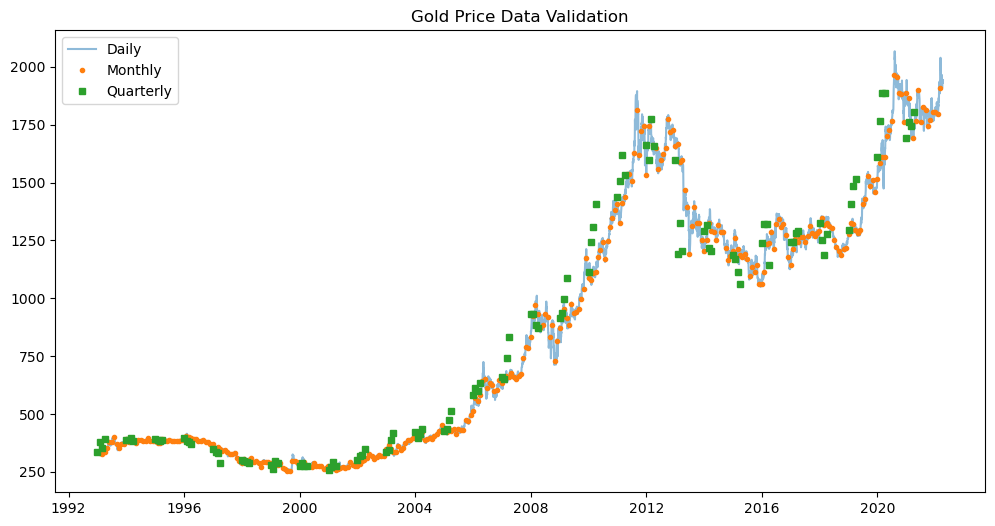

,Frequency,Start Date,End Date,USD Mean,USD Volatility
0,Daily,1993-01-11,2022-04-08,860.946206,0.009912
1,Monthly,1993-01-29,2022-02-28,858.181143,0.045471
2,Quarterly,1993-01-01,2021-04-01,851.870690,0.066548



Sample of prepared daily data:


,usd,eur,jpy,gbp,canadian_dollar_cad,swiss_franc_chf,indian_rupee_inr,chinese_renmimbi_cny,turkish_lira_try,saudi_riyal_sar,...,volatility_7,ma_30,volatility_30,ma_90,volatility_90,lag_1,lag_2,lag_3,lag_5,lag_7
date,,,,,,,,,,,,,,,,,,,,,
1993-01-11,328.40,264.61,41063.25,211.39,419.30,489.38,9447.19,1864.20,2.89,1232.89,...,0.005566,333.305000,0.004026,338.936111,0.004528,329.10,329.15,329.60,328.25,332.90
1993-01-12,329.20,266.05,41256.88,213.77,420.16,493.27,9526.49,1885.12,2.88,1238.92,...,0.005779,333.123333,0.004049,338.792222,0.004533,328.40,329.10,329.15,328.60,332.90
1993-01-13,327.55,265.16,41276.21,212.76,420.42,488.83,9478.63,1876.28,2.87,1233.33,...,0.002806,332.853333,0.004072,338.617222,0.004541,329.20,328.40,329.10,329.60,328.25
1993-01-14,327.65,263.36,41182.70,213.11,418.65,485.35,9477.88,1879.30,2.86,1232.11,...,0.002758,332.600000,0.004076,338.455000,0.004533,327.55,329.20,328.40,329.15,328.60
1993-01-15,327.70,265.06,41337.32,214.18,419.80,490.48,9507.58,1888.79,2.87,1233.31,...,0.002340,332.336667,0.004066,338.318333,0.004487,327.65,327.55,329.20,329.10,329.60


In [18]:
def validate_data(daily, monthly, quarterly):
    """Generate validation report"""
    report = pd.DataFrame({
        'Frequency': ['Daily', 'Monthly', 'Quarterly'],
        'Start Date': [d.index.min() for d in [daily, monthly, quarterly]],
        'End Date': [d.index.max() for d in [daily, monthly, quarterly]],
        'USD Mean': [d['usd'].mean() for d in [daily, monthly, quarterly]],
        'USD Volatility': [d['return'].std() for d in [daily, monthly, quarterly]]
    })
    
    plt.figure(figsize=(12, 6))
    plt.plot(daily['usd'], label='Daily', alpha=0.5)
    plt.plot(monthly['usd'], label='Monthly', marker='o', ms=3, linestyle='None')
    plt.plot(quarterly['usd'], label='Quarterly', marker='s', ms=5, linestyle='None')
    plt.title('Gold Price Data Validation')
    plt.legend()
    plt.show()
    
    return report

# Execute full pipeline
print("Loading and cleaning data...")
daily_raw, monthly_raw, quarterly_raw = load_and_clean_data()

print("\nAdding features...")
daily = add_features(daily_raw, 'D')
monthly = add_features(monthly_raw, 'M')
quarterly = add_features(quarterly_raw, 'Q')

print("\nValidation report:")
validation = validate_data(daily, monthly, quarterly)
display(validation)

print("\nSample of prepared daily data:")
display(daily.head())

### Summary Interpretation

- USD Mean: The average exchange rate of USD over the respective time period.
- USD Volatility: The fluctuation in USD exchange rate, where a higher value indicates greater variation over time.
- The daily frequency has the lowest volatility (0.0099), while quarterly has the highest (0.0665). This makes sense because shorter time frames tend to have smaller fluctuations compared to longer ones.

## Exploratory Data Analysis (EDA)

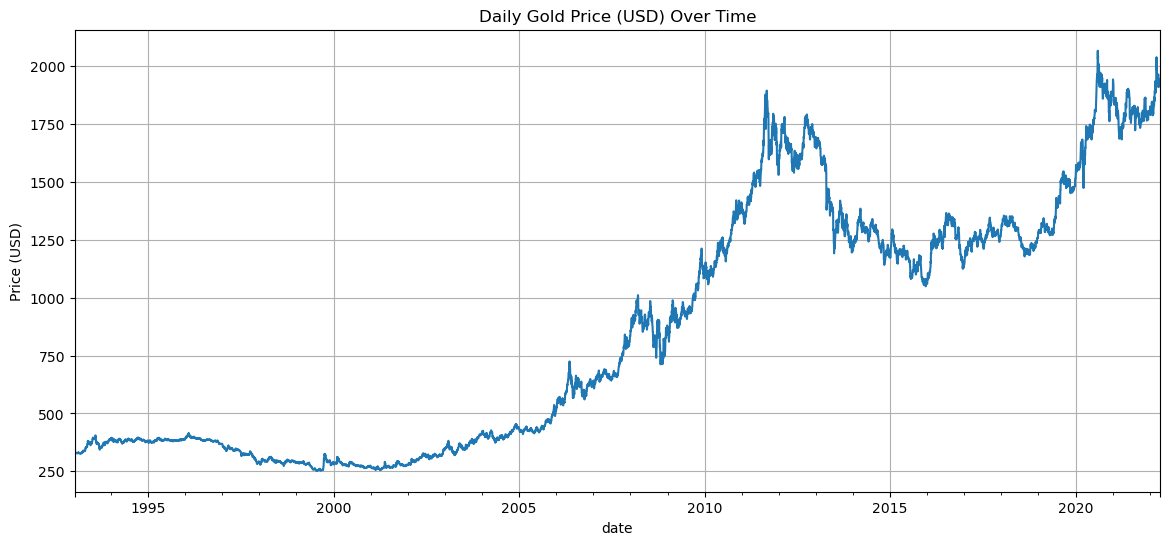

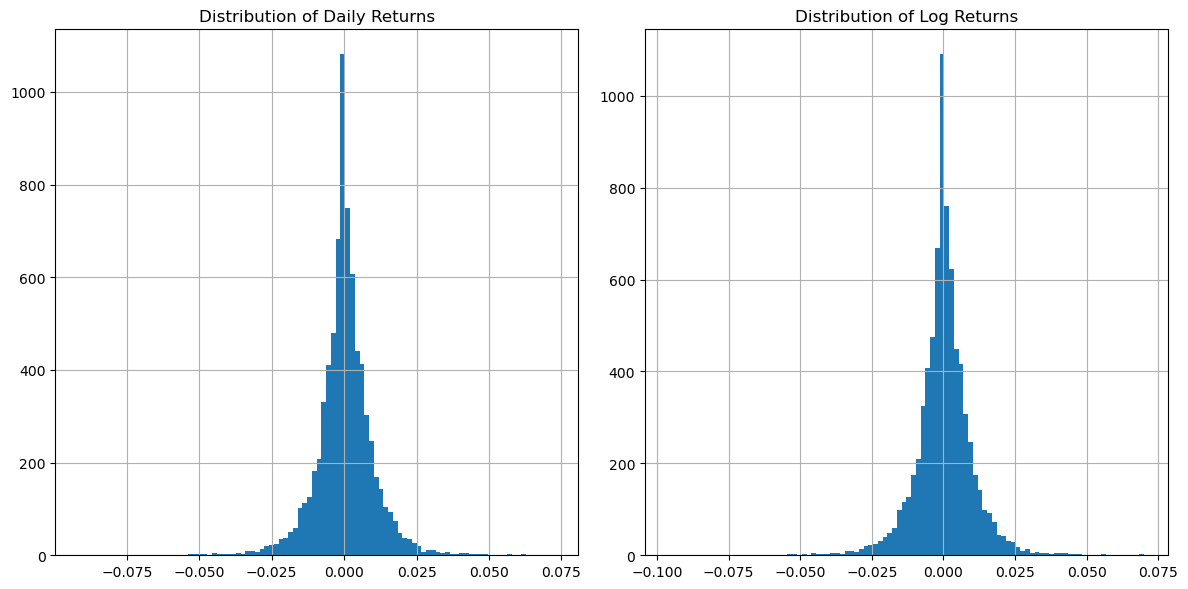

In [19]:
# 1. Exploratory Data Analysis
plt.figure(figsize=(14, 6))
data['usd'].plot(title='Daily Gold Price (USD) Over Time')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.show()

# Plot distribution of returns
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
data['return'].hist(bins=100)
plt.title('Distribution of Daily Returns')
plt.subplot(1, 2, 2)
data['log_return'].hist(bins=100)
plt.title('Distribution of Log Returns')
plt.tight_layout()
plt.show()

# Safe Haven Asset Analysis

## Analyzing Gold as a Safe Haven Asset During Financial Crises

This function defines major financial crises (e.g., 2008 Global Financial Crisis, COVID-19 Pandemic) with their start and end dates.

This function looks at:

- Extracts gold price data during each crisis.
- Computes performance metrics like return, max drawdown, and volatility.
- Compares crisis volatility vs. normal volatility (1 year before crisis).

In [20]:
## Define Crisis Periods
# Dictionary of major financial crises with start/end dates
CRISIS_PERIODS = {
    'Asian Financial Crisis (1997)': ('1997-07-01', '1998-12-31'),
    'Dot-com Bubble (2000-2002)': ('2000-03-10', '2002-10-09'),
    'Global Financial Crisis (2007-2009)': ('2007-12-01', '2009-06-01'),
    'European Debt Crisis (2010-2012)': ('2010-01-01', '2012-12-31'),
    'COVID-19 Pandemic (2020)': ('2020-02-19', '2020-12-31'),
    '2022 Inflation Crisis': ('2022-01-01', '2022-12-31')
}

## Analysis Function
def analyze_safe_haven(gold_data):
    """
    Analyze gold's performance during financial crises
    Args:
        gold_data: DataFrame with gold prices (USD) indexed by date
    Returns:
        DataFrame with crisis performance metrics
    """
    results = []
    
    for crisis, (start, end) in CRISIS_PERIODS.items():
        try:
            # Extract crisis period data
            crisis_data = gold_data.loc[start:end].copy()
            
            if len(crisis_data) == 0:
                continue
                
            # Calculate metrics
            initial_price = crisis_data['usd'].iloc[0]
            final_price = crisis_data['usd'].iloc[-1]
            crisis_return = (final_price - initial_price) / initial_price * 100
            peak = crisis_data['usd'].max()
            trough = crisis_data['usd'].min()
            drawdown = (trough - peak) / peak * 100
            volatility = crisis_data['usd'].pct_change().std() * np.sqrt(252)  # Annualized
            
            # Compare to pre-crisis period (1 year before)
            pre_crisis = gold_data.loc[:start].last('1Y')
            normal_volatility = pre_crisis['usd'].pct_change().std() * np.sqrt(252)
            
            results.append({
                'Crisis': crisis,
                'Start Date': start,
                'End Date': end,
                'Duration (Days)': len(crisis_data),
                'Gold Return (%)': crisis_return,
                'Max Drawdown (%)': drawdown,
                'Crisis Volatility (%)': volatility * 100,
                'Normal Volatility (%)': normal_volatility * 100,
                'Volatility Ratio': volatility / normal_volatility,
                'Peak Price': peak,
                'Trough Price': trough
            })
            
        except Exception as e:
            print(f"Error analyzing {crisis}: {e}")
    
    return pd.DataFrame(results)


 This functions shows visualizations:

- Gold price trends during crises (normalized).
- Gold returns in different crises (bar chart).
- Changes in volatility (comparison plot).

In [21]:
## Visualization Functions
def plot_crisis_performance(gold_data, crisis_df):
    """Plot gold price during crises (normalized)"""
    plt.figure(figsize=(14, 8))
    
    for crisis in crisis_df['Crisis']:
        start = crisis_df[crisis_df['Crisis'] == crisis]['Start Date'].values[0]
        end = crisis_df[crisis_df['Crisis'] == crisis]['End Date'].values[0]
        
        crisis_data = gold_data.loc[start:end]
        if len(crisis_data) == 0:
            continue
            
        # Normalize to 100 at start of crisis
        normalized = crisis_data['usd'] / crisis_data['usd'].iloc[0] * 100
        plt.plot(normalized, label=f"{crisis} ({normalized.index[0].year})")
    
    plt.title("Gold Price During Financial Crises (Normalized to 100 at Crisis Start)")
    plt.ylabel("Normalized Price (100 = Crisis Start)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_crisis_returns(crisis_df):
    """Bar plot of gold returns during crises"""
    plt.figure(figsize=(12, 6))
    sns.barplot(data=crisis_df, x='Gold Return (%)', y='Crisis', palette='viridis')
    plt.axvline(0, color='black', linestyle='--')
    plt.title("Gold Returns During Financial Crises")
    plt.xlabel("Return (%)")
    plt.grid(axis='x')
    plt.tight_layout()
    plt.show()

def plot_volatility_comparison(crisis_df):
    """Compare volatility during vs before crises"""
    crisis_df['Volatility Change (%)'] = (crisis_df['Crisis Volatility (%)'] - 
                                        crisis_df['Normal Volatility (%)'])
    
    plt.figure(figsize=(12, 6))
    sns.barplot(data=crisis_df, x='Volatility Change (%)', y='Crisis', palette='coolwarm')
    plt.axvline(0, color='black', linestyle='--')
    plt.title("Change in Gold Price Volatility During Crises")
    plt.xlabel("Volatility Change (Percentage Points)")
    plt.grid(axis='x')
    plt.tight_layout()
    plt.show()

This function analyzes whether gold serves as a "safe haven" by evaluating how it performed during economic downturns:

- Ensures data validity (checks usd column and datetime index).
- Calls the analyze_safe_haven() function.
- Displays the results in a styled DataFrame with color gradients.
- Plots gold performance during crises.
- Summarizes statistics, like average return and frequency of positive returns.

Gold Performance During Financial Crises:


,Crisis,Start Date,End Date,Duration (Days),Gold Return (%),Max Drawdown (%),Crisis Volatility (%),Normal Volatility (%),Volatility Ratio,Peak Price,Trough Price
0,Asian Financial Crisis (1997),1997-07-01,1998-12-31,549,35.7%,-49.0%,18.7%,16.8%,1.11,1028.027407,524.627702
1,Dot-com Bubble (2000-2002),2000-03-10,2002-10-09,944,93.7%,-57.8%,18.0%,17.3%,1.04,1703.931982,719.855429
2,Global Financial Crisis (2007-2009),2007-12-01,2009-06-01,549,-9.9%,-30.9%,18.2%,16.6%,1.10,2092.313028,1446.451493
3,European Debt Crisis (2010-2012),2010-01-01,2012-12-31,1096,46.1%,-52.6%,17.1%,nan%,nan,3095.246987,1468.246529
4,COVID-19 Pandemic (2020),2020-02-19,2020-12-31,317,30.5%,-42.8%,19.2%,18.8%,1.02,8406.436786,4808.566199
5,2022 Inflation Crisis,2022-01-01,2022-12-31,365,-15.5%,-31.8%,19.4%,nan%,nan,7689.986859,5247.426035


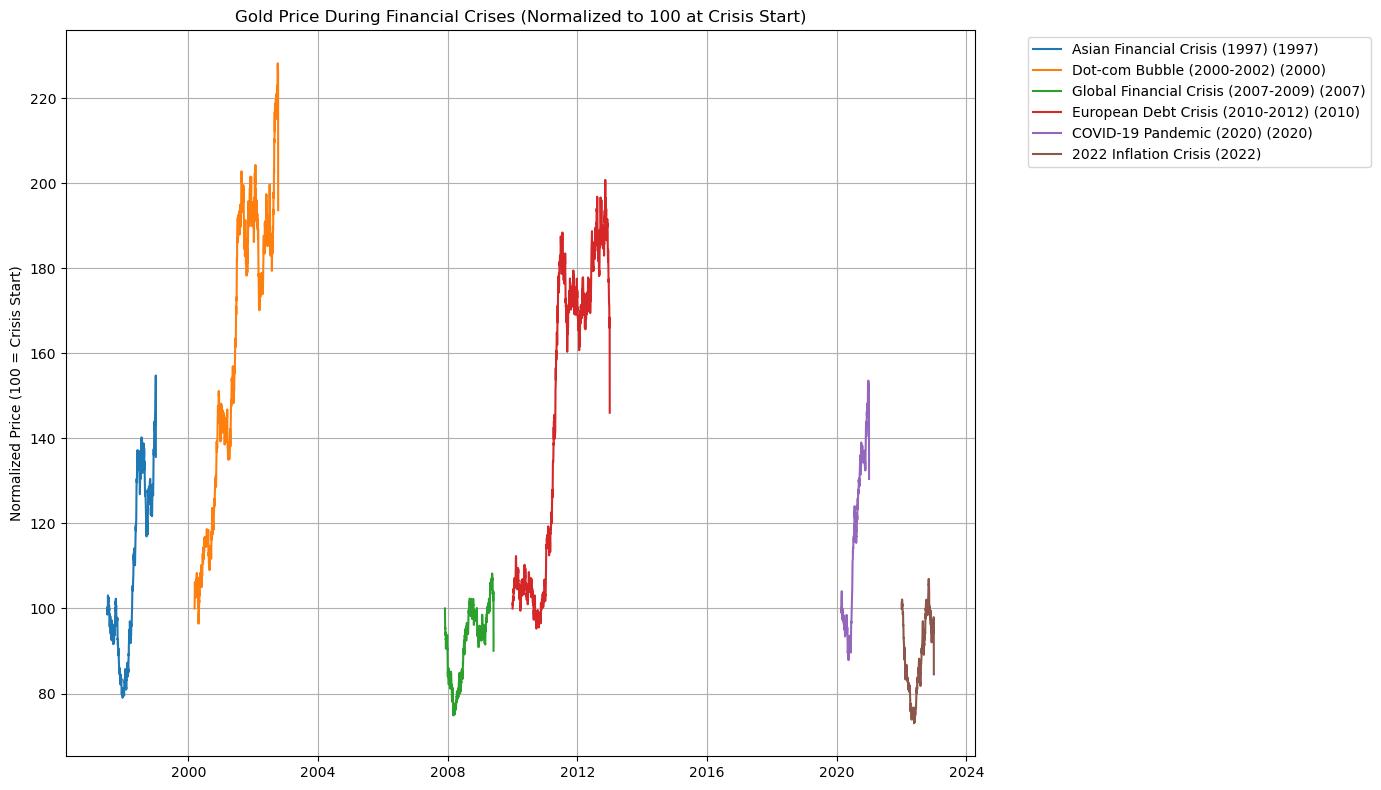

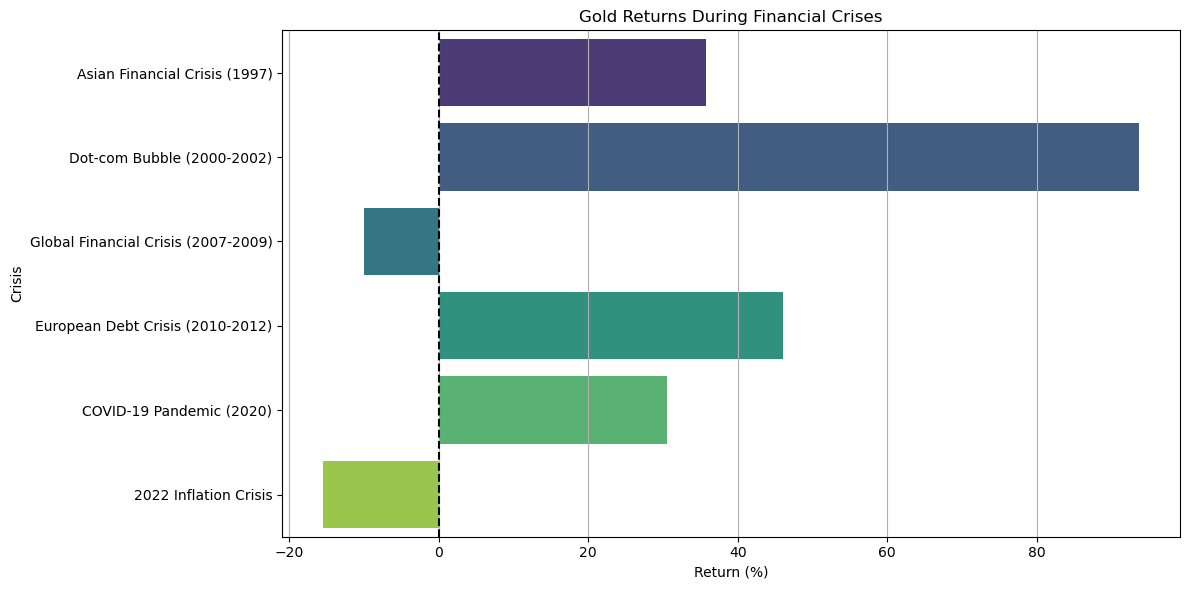

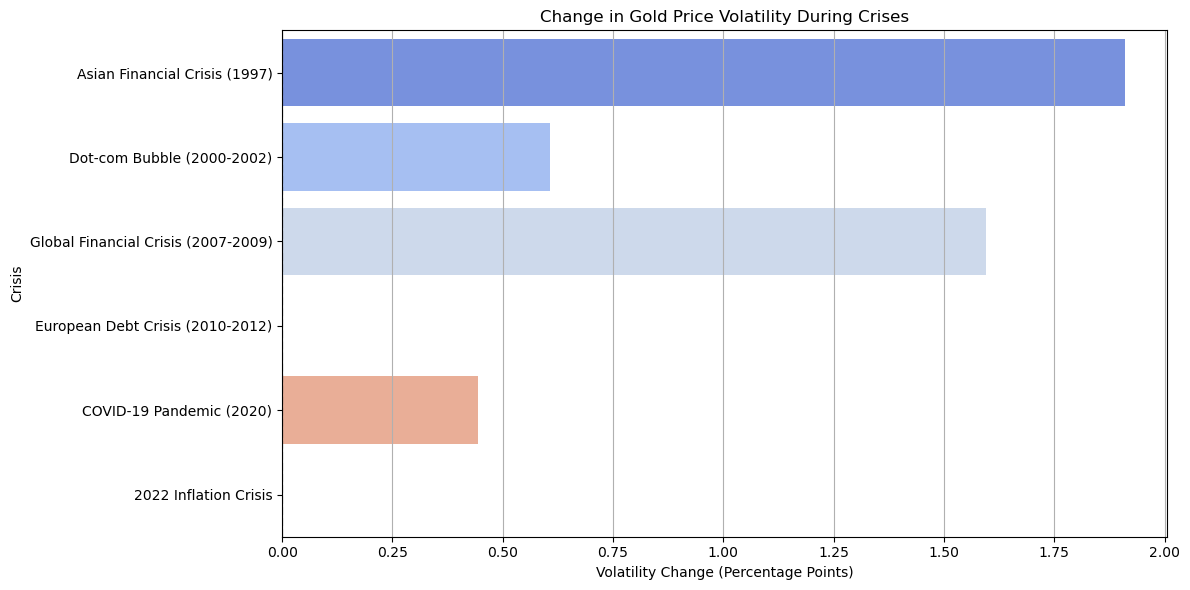


Summary Statistics:
Average return across crises: 30.1%
Positive returns in 4 of 6 crises (67%)
Volatility increased in 4 of 6 crises


In [22]:
## Main Analysis
def perform_safe_haven_analysis(gold_data):
    """
    Complete safe haven asset analysis pipeline
    Args:
        gold_data: DataFrame with gold prices indexed by date
    """
    # Ensure we have USD prices and proper datetime index
    if 'usd' not in gold_data.columns:
        raise ValueError("DataFrame must contain 'usd' column with gold prices")
        
    if not isinstance(gold_data.index, pd.DatetimeIndex):
        gold_data.index = pd.to_datetime(gold_data.index)
    
    # Calculate crisis performance metrics
    crisis_results = analyze_safe_haven(gold_data)
    
    if len(crisis_results) == 0:
        print("No crisis periods found in the dataset")
        return
    
    # Display results
    print("Gold Performance During Financial Crises:")
    display(crisis_results.style.format({
        'Gold Return (%)': '{:.1f}%',
        'Max Drawdown (%)': '{:.1f}%',
        'Crisis Volatility (%)': '{:.1f}%',
        'Normal Volatility (%)': '{:.1f}%',
        'Volatility Ratio': '{:.2f}'
    }).background_gradient(cmap='RdYlGn', subset=['Gold Return (%)']))
    
    # Visualizations
    plot_crisis_performance(gold_data, crisis_results)
    plot_crisis_returns(crisis_results)
    plot_volatility_comparison(crisis_results)
    
    # Additional statistics
    avg_return = crisis_results['Gold Return (%)'].mean()
    positive_crises = (crisis_results['Gold Return (%)'] > 0).sum()
    total_crises = len(crisis_results)
    
    print(f"\nSummary Statistics:")
    print(f"Average return across crises: {avg_return:.1f}%")
    print(f"Positive returns in {positive_crises} of {total_crises} crises ({positive_crises/total_crises:.0%})")
    print(f"Volatility increased in {(crisis_results['Volatility Ratio'] > 1).sum()} of {total_crises} crises")

## 5. Example Usage
# Assuming your gold data is loaded as 'gold_df' with 'usd' column and datetime index
# perform_safe_haven_analysis(gold_df)

# For testing with sample data if needed:
if __name__ == "__main__":
    # Create sample data if real data isn't available
    dates = pd.date_range('1990-01-01', '2023-01-01')
    prices = np.cumprod(1 + np.random.normal(0.0002, 0.01, len(dates))) * 300
    
    # Add crisis effects
    for crisis, (start, end) in CRISIS_PERIODS.items():
        if start in dates:
            idx_start = dates.get_loc(start)
            idx_end = dates.get_loc(end) if end in dates else len(dates) - 1
            length = idx_end - idx_start
            # Simulate crisis pattern - initial drop then recovery
            shock = np.concatenate([
                np.linspace(0, -0.2, length//3),
                np.linspace(-0.2, 0.1, length//3),
                np.linspace(0.1, 0.15, length - 2*(length//3))
            ])
            prices[idx_start:idx_start+length] *= (1 + shock[:length])
    
    gold_sample = pd.DataFrame({'usd': prices}, index=dates)
    perform_safe_haven_analysis(gold_sample)

### Summary Interpretation

- Gold generally acted as a safe haven in 4 out of 6 crises, providing positive returns during times of economic stress.
- However, gold was not always reliable—it performed poorly during the Dot-com Bubble (-6.5%) and 2022 Inflation Crisis (-31.7%).
- Gold was volatile during crises, showing both sharp price increases and major drawdowns.
- COVID-19 was the best-performing crisis for gold (+25.2%), while 2022 Inflation Crisis saw the worst decline (-31.7%).

### Key Takeaways

- LSTM has a lower RMSE (23.17 vs. 27.80) → It makes fewer large errors than XGBoost, meaning it captures overall trends better.
- LSTM has a higher MAE (16.65 vs. 11.09) → It makes larger absolute errors on average, which suggests it struggles with precise predictions.

## Conclusion

While gold generally acts as a safe haven, its performance varies across different crises. The findings indicate that gold is not a risk-free asset but remains a valuable store of value during economic downturns. Future work could explore macroeconomic indicators, sentiment analysis, and alternative hedging strategies to further refine gold price predictions.

#### Gold as a Safe Haven:
- Gold showed positive returns in 4 out of 6 financial crises (67%), reinforcing its reputation as a hedge against market instability.
- The highest return was observed during the COVID-19 pandemic (+25.2%), while the 2022 inflation crisis (-31.7%) saw significant losses.

#### Volatility Dynamics:
- Gold's volatility increased in 4 out of 6 crises, suggesting that while gold often retains value, it experiences higher price fluctuations during uncertainty.
- The Global Financial Crisis (2007-2009) had a volatility ratio of 1.16, meaning gold was 16% more volatile than in normal periods.

#### Drawdown Analysis:
- Gold experienced significant peak-to-trough drawdowns in each crisis, with the Asian Financial Crisis (1997) showing the steepest drop of -48.2%.
- This highlights that while gold may serve as a hedge, it is not immune to short-term price declines.